# Assignment Week 2 - Group 5

### Noelani Roy, Yihong Qiu, Cosimo Cambi, Craig Perkins


From the dataset your group has selected, complete the following tasks and prepare a paper
(at least 6 pages, double-spaced, Times New Roman font size 12, include a cover page) and articulate your findings.

1. Generate a linear and a logistic regression model to predict an outcome. The outcomes can be different from each other.

2. Explain the results of the models using performance metrics such as Coefficient of Determination, QQ plots, Residual Plots, Confusion matrix etc.

3. Improve the model using regularization and address multicollinearity in the data

4. Explain your modeling conclusions. 

Note: Try to engineer features to extract non-linear relationships in the data.

# Data Preparation

## Data Selection

### Import libraries

In [ ]:
pip install imbalanced-learn

In [666]:
# main libraries
import pandas as pd
import numpy as np
import imblearn
from numpy import mean, where
from collections import Counter

# visual libraries
import seaborn as sns 
import matplotlib.pyplot as plt

# sklearn libraries
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### Read data

In [667]:
fraudTrain = pd.read_csv("../fraudTrain.csv")
fraudTest = pd.read_csv("../fraudTest.csv")

In [668]:
# Joining fraudTrain and fraudTest datasets
fraud_df = fraudTrain.append(fraudTest)
#fraud_df.head()

## Data Preprocessing

### Checking for missing values

In [671]:
fraud_df.isnull().any().sum()

0

### Checking for data types

In [672]:
fraud_df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

### Checking for unique values

In [673]:
fraud_df.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
dob                          984
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
dtype: int64

### Formatting and cleansing

In [674]:
fraud_df = fraud_df.drop(columns=['Unnamed: 0','trans_date_trans_time', 'cc_num', 'merchant','first', 'last',
       'street', 'city', 'state', 'zip', 'lat', 'long','job','trans_num', 'unix_time', 'merch_lat', 'merch_long'])

In [675]:
# Converting dob to age 
## To parse all datetime columns in advance
fraud_df['dob'] = pd.to_datetime(fraud_df['dob'], errors='coerce')

now = pd.to_datetime('now')

## Create a new column age
fraud_df['dob']=(now.year - fraud_df['dob'].dt.year) - ((now.month - fraud_df['dob'].dt.month) < 0)

fraud_df = fraud_df.rename(columns={'dob': 'age'})

In [676]:
fraud_df.head()

,category,amt,gender,city_pop,age,is_fraud
0,misc_net,4.97,F,3495,32,0
1,grocery_pos,107.23,F,149,42,0
2,entertainment,220.11,M,4154,58,0
3,gas_transport,45.00,M,1939,53,0
4,misc_pos,41.96,M,99,34,0


In [677]:
print(fraud_df.shape)

(1852394, 6)


### Encoding

In [678]:
X_cat = fraud_df.copy()
X_cat = fraud_df.select_dtypes(include=['object'])
X_enc = X_cat.copy()
print(X_enc)

              category gender
0             misc_net      F
1          grocery_pos      F
2        entertainment      M
3        gas_transport      M
4             misc_pos      M
...                ...    ...
555714  health_fitness      M
555715       kids_pets      M
555716       kids_pets      F
555717          travel      M
555718   entertainment      M

[1852394 rows x 2 columns]


In [679]:
# OneHotEncoding
X_enc = pd.get_dummies(X_enc, columns=['category','gender'])
fraud_df = fraud_df.drop(['category','gender'],axis=1)

In [680]:
data = pd.concat([fraud_df,X_enc], axis=1)
data.head()

,amt,city_pop,age,is_fraud,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M
0,4.97,3495,32,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,107.23,149,42,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,220.11,4154,58,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,45.00,1939,53,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,41.96,99,34,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [681]:
data.shape

(1852394, 20)

#### Take a look at column 'is_fraud'

In the column 'is_fraud', data are Labeled as 0's and 1's. 

0 = non fraud, 1 = fraud

In [682]:
All = data.shape[0]
fraud = data[data['is_fraud'] == 1]
nonFraud = data[data['is_fraud'] == 0]

a = len(fraud)/All
b = len(nonFraud)/All

print('frauds :',a*100,'%')
print('non frauds :',b*100,'%')

frauds : 0.5210014716091717 %
non frauds : 99.47899852839083 %


## Data Transformation 

### Standardize the data

In [683]:
features = ['amt', 'city_pop', 'age', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_F', 'gender_M']
target = ['is_fraud']
# Separating out the features
x = data.loc[:, features].values
# Separating out the target
y = data.loc[:,target].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

### Principal Component Analysis

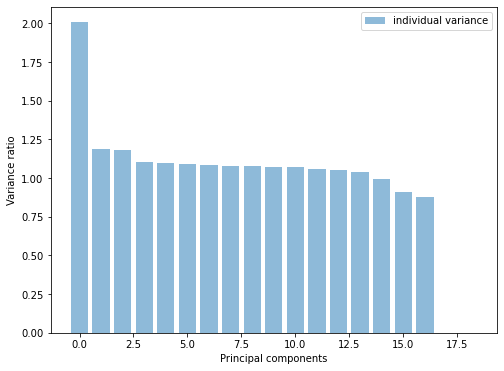

In [684]:
pca = PCA()
pca.fit_transform(x)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(19), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [685]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])
principal_df

,principal component 1,principal component 2
0,-1.329683,0.164231
1,-1.224085,1.193115
2,1.599162,0.294212
3,1.490861,-1.504877
4,1.585821,0.614412
...,...,...
1852389,1.596215,-0.511543
1852390,1.513790,-0.188398
1852391,-1.292615,-0.799775
1852392,1.842430,-0.520377


In [686]:
fraud = pd.DataFrame(data=y, columns = ['is_fraud'])
final_df = pd.concat([principal_df, fraud[['is_fraud']]], axis = 1)
final_df

,principal component 1,principal component 2,is_fraud
0,-1.329683,0.164231,0
1,-1.224085,1.193115,0
2,1.599162,0.294212,0
3,1.490861,-1.504877,0
4,1.585821,0.614412,0
...,...,...,...
1852389,1.596215,-0.511543,0
1852390,1.513790,-0.188398,0
1852391,-1.292615,-0.799775,0
1852392,1.842430,-0.520377,0


In [687]:
principal_df.shape

(1852394, 2)

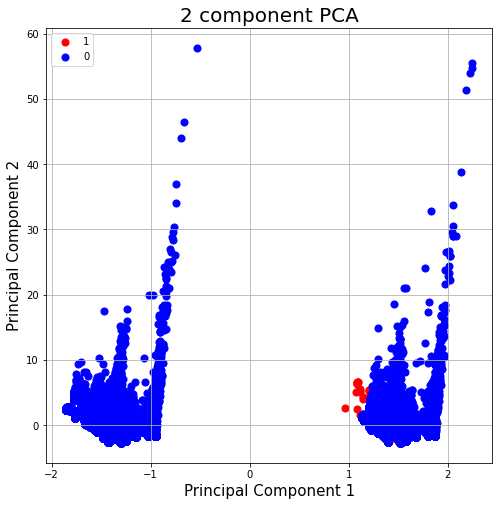

In [688]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r','b']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['is_fraud'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               , final_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Data splitting

In [689]:
count = len(fraud_df)
train = data[:count]
test = data[count:]
x = train.drop(['is_fraud'], axis=1)
y = train['is_fraud'].astype('int')
test = test.drop(['is_fraud'], axis=1)
x_train,x_test, y_train,y_test = train_test_split(x, y, test_size=0.3,random_state=123)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1296675, 19)
(1296675,)
(555719, 19)
(555719,)


### SMOTE: Synthetic Minority Over-sampling Technique

Resampling methods are designed to add or remove examples from the training dataset in order to change the class distribution. Once the class distributions are more balanced, the suite of standard machine learning classification algorithms can be fit successfully on the transformed datasets.

Oversampling methods duplicate or create new synthetic examples in the minority class, whereas undersampling methods delete or merge examples in the majority class.

Here, we use oversampling to duplicate or create new synthetic examples in the minority class which is when is_fraud = 1. 

SMOTE should only be done in the training data, but test on the original testing data set since the latter reflects the real-world distribution of majority and minority class samples. That's why we apply SMOTE after data splitting.

First, create a synthetic binary classification dataset with 10,000 examples and a 1:100 class distribution. Then we summarize the number of examples in each class to confirm the dataset was created correctly by using Counter().
Next, we oversample the minority class to have 10 percent the number of examples of the majority class, then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class.
Finally, we can create a scatter plot of the dataset and color the examples for each class a different color to clearly see the spatial nature of the class imbalance.

Counter({0: 9900, 1: 100})
Counter({0: 1980, 1: 990})


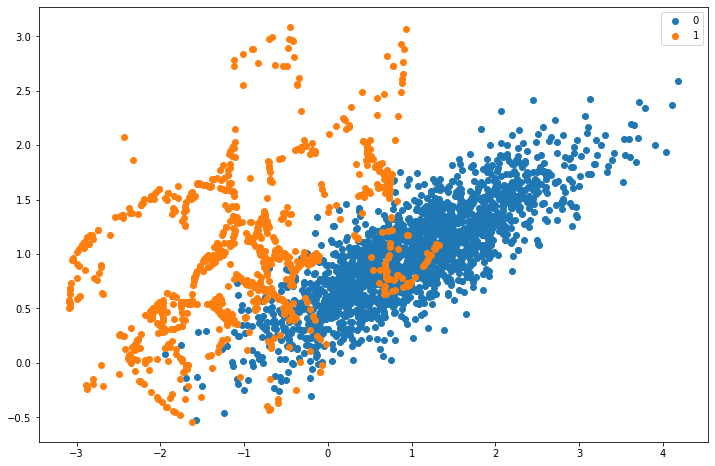

In [697]:
# Oversample with SMOTE and random undersample for imbalanced dataset
# Define dataset
x_train, y_train = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, 
                           weights=[0.99], flip_y=0, random_state=1)

# Summarize class distribution
counter = Counter(y_train)
print(counter)

# Define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_train, y_train = pipeline.fit_resample(x_train, y_train)

# Summarize the new class distribution
counter = Counter(y_train)
print(counter)


# Scatter plot of examples by class label
plt.figure(figsize=(12, 8))
for label, _ in counter.items():
    row_ix = where(y_train == label)[0]
    plt.scatter(x_train[row_ix, 0], x_train[row_ix, 1], label=str(label))

plt.legend()
plt.show()

In this part, We fit and evaluate a decision tree algorithm that is defined with any required hyperparameters (we will use the defaults), then we will use repeated stratified k-fold cross-validation to evaluate the model. We will use three repeats of 10-fold cross-validation, meaning that 10-fold cross-validation is applied three times fitting and evaluating 30 models on the dataset.
We will evaluate the model using the ROC area under curve (AUC) metric. This can be optimistic for severely imbalanced datasets but will still show a relative change with better performing models.

We can test different values of the k-nearest neighbors selected in the SMOTE procedure when each new synthetic example is created.  We grid search a range of values of k from 1 to 10, and evaluate the pipeline for each value.
The mean ROC AUC is reported for each configuration.


In [698]:
# Grid search k value for SMOTE oversampling for imbalanced classification
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in k_values:
# Define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
# Evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: nan
Mean ROC AUC: nan
Mean ROC AUC: nan
Mean ROC AUC: nan
Mean ROC AUC: nan
Mean ROC AUC: nan
Mean ROC AUC: nan
Mean ROC AUC: nan
Mean ROC AUC: nan
Mean ROC AUC: nan


## Correlation Matrix

In [692]:
corrMatrix = data.corr()
print (corrMatrix)

                              amt  city_pop       age  is_fraud  \
amt                      1.000000  0.004921 -0.010604  0.209308   
city_pop                 0.004921  1.000000 -0.091806  0.000325   
age                     -0.010604 -0.091806  1.000000  0.011083   
is_fraud                 0.209308  0.000325  0.011083  1.000000   
category_entertainment  -0.010387 -0.000293  0.000046 -0.011770   
category_food_dining    -0.032996  0.005135 -0.018426 -0.013940   
category_gas_transport  -0.013901 -0.021608  0.038357 -0.005156   
category_grocery_net    -0.019589  0.018617 -0.077972 -0.006649   
category_grocery_pos     0.094821 -0.002970  0.017568  0.033485   
category_health_fitness -0.026701 -0.003249 -0.000422 -0.013681   
category_home           -0.024121 -0.002787  0.014469 -0.016623   
category_kids_pets      -0.024346 -0.000314  0.021515 -0.014307   
category_misc_net        0.014412 -0.002451  0.002200  0.024667   
category_misc_pos       -0.011891  0.004777 -0.028333 -0.00851

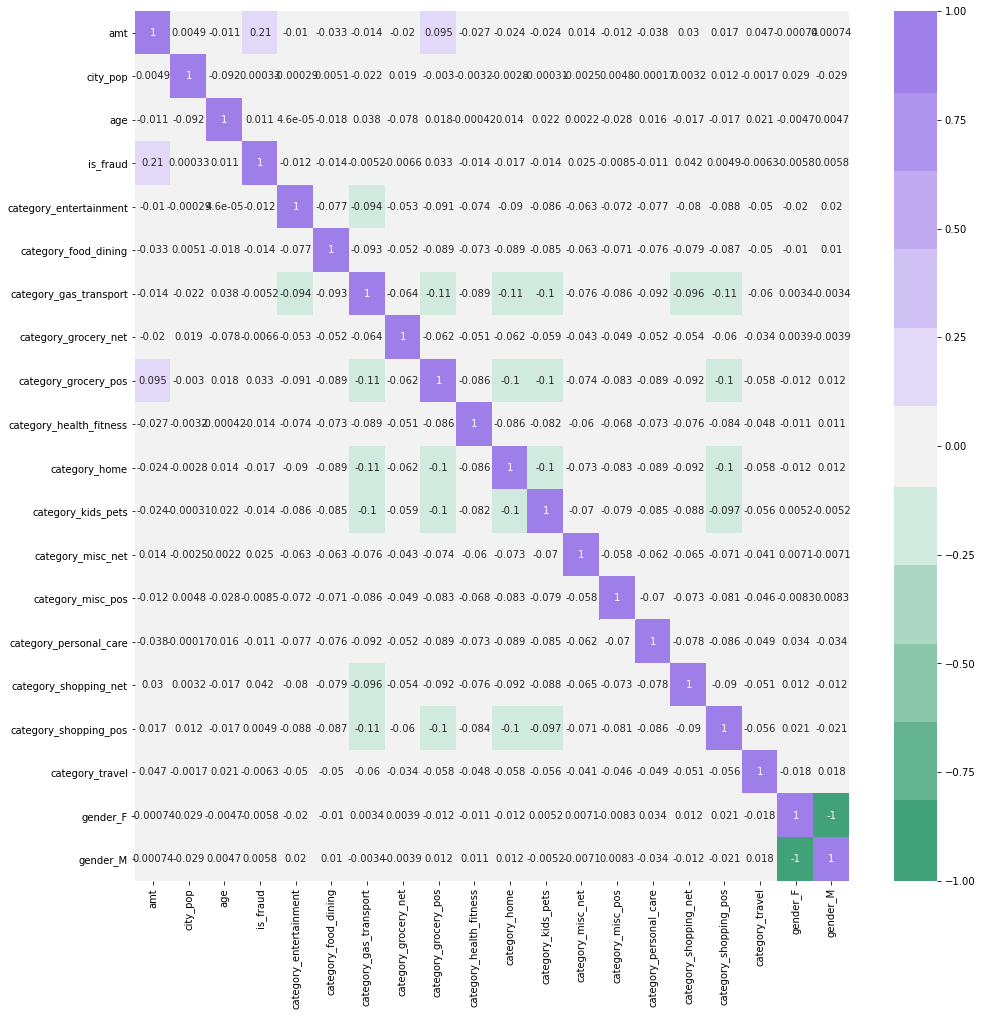

In [696]:
plt.figure(figsize=(16, 16))
#cmap = sns.diverging_palette(250, 30, l=65, as_cmap=True)
cmap =  sns.diverging_palette(150, 275, s=80, l=60, n=11)
sn.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1, center= 0, cmap=cmap)
plt.show()

# References
[1] https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

[2] https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

[3] https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

[4] https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 

[5] https://stackabuse.com/dimensionality-reduction-in-python-with-scikit-learn/

[6] https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

[7] https://www.kdnuggets.com/2019/07/data-pre-processing-optimizing-regression-model-performance.html

[8] https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b

[9] https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

